<a href="https://colab.research.google.com/github/ndreoo/ISBI/blob/main/MxMH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall tensorflow

Found existing installation: tensorflow 2.16.1
Uninstalling tensorflow-2.16.1:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.16.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.16.1


In [ ]:
!pip install tensorflow==2.15

In [ ]:
!pip install keras

In [ ]:
#@title Imports and Read in Data

#Importing revelant libraries and installing facets for visualisation
import pandas as pd  #gestione dati tabellari
import matplotlib.pyplot as plt
from numpy import*
from sklearn import*
import tensorflow as tf
from tensorflow import keras
import numpy as np


# sklearn encoding, data preparation and evaluation tools
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix



from keras.layers import Dense, SpatialDropout3D
from keras.models import Sequential

seed = 1
# fix random seed for reproducibility
np.random.seed(seed)                  #garantisce la riproducibilità degli stessi numeri casuali ad ogni esecuzione

# Some matplotlib figure sizes
plt.rcParams["figure.figsize"] = (12,8)


# For facets
from IPython.core.display import display, HTML
import base64
!pip install --upgrade facets-overview      #scarico la versione più recente. Facets serve a fornire delle statistiche sui dati
from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator


# Opening the file from github
filename = "/content/sample_data/mxmh_survey_results.csv"

data = pd.read_csv(filename)            #creo un dataframe leggendo un csv tramite pandas

# replacing blank spaces with '_'       #Questa operazione serve, in quanto le query tramite Pandas non funzionano per le colonne in cui sono presenti spazi
#data.columns = [column.replace(" ", "_") for column in data.columns]
del data['Permissions']
del data['Timestamp']
data.describe()



,Age,Hours per day,BPM,Anxiety,Depression,Insomnia,OCD
count,735.000000,736.000000,6.290000e+02,736.000000,736.000000,736.000000,736.000000
mean,25.206803,3.572758,1.589948e+06,5.837636,4.796196,3.738451,2.637228
std,12.054970,3.028199,3.987261e+07,2.793054,3.028870,3.088689,2.842017
min,10.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,18.000000,2.000000,1.000000e+02,4.000000,2.000000,1.000000,0.000000
50%,21.000000,3.000000,1.200000e+02,6.000000,5.000000,3.000000,2.000000
75%,28.000000,5.000000,1.440000e+02,8.000000,7.000000,6.000000,5.000000
max,89.000000,24.000000,1.000000e+09,10.000000,10.000000,10.000000,10.000000


In [ ]:
!pip install tensorflow-data-validation  #TensorFlow Data Validation identifica eventuali anomalie
                                        #nei dati di input confrontando le statistiche dei dati con uno schema.
                                        #Lo schema codifica le proprietà che i dati di input dovrebbero soddisfare,
                                        #come tipi di dati o valori categoriali, e può essere modificato o sostituito dall'utente.

  Using cached tensorflow-2.16.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (589.8 MB)
  Using cached ml_dtypes-0.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.2 MB)
  Using cached tensorboard-2.16.2-py3-none-any.whl (5.5 MB)
  Using cached keras-3.1.1-py3-none-any.whl (1.1 MB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
ERROR: pip's dependency 

# **Eliminazione dati sporchi**

In [ ]:
# Used to label encode categorical values
labelencoder = LabelEncoder()


print(data.describe())

print("\n\n Missing values ")
print((data == '').sum())

# Converting missing data to NaN
data.replace('', np.nan, inplace=True)

# here we are dropping the NaN values, this is not ideal, and you will be asked questions on this later
data.dropna(inplace=True)

print("\n\n Missing values  after del")
print((data == '').sum())


# This code identifies columns that need label encoding, and are then formatted if they do
print("\n\nColumn Names & formatting:\n")
for col in data.columns.values.tolist():
    if data[col].dtype == "object" or data[col].dtype == "bool":
        print("{:<30}".format(col), ":", "{:<30}".format(str(data[col].dtype)) , "Formatting to LabelEncoding")
        data[col] = labelencoder.fit_transform(data[col])
    else:
        print("{:<30}".format(col), ":", "{:<30}".format(str(data[col].dtype)) , "No formatting required.")

#WE WORKED IN PANDAS, MANAGING THE DATA LIKE A TABLE WITH ALSO NOT NUMERIC ELEMENT
#NOW, WITH THIS CONVERSION WE WORK IN NUMPY - IN NUMERIC DOMAIN
# Convert to array
#CREATING A MATRIX STARTING FROM THE TABLE
array = data.values

#we start from pandas table and arrive to numpy matrix (mandatory numeric)


# get seperated input and classifies, using a deep copy of a list, this is for ML models
X = array[:,0:30]
Y = array[:,30]

# Optional: to speed up deep learning model training - try this after algorithm development if the results are poor.
#----------------------------------------------------------
# Normalizing the input values (excluding the class value)
scaler = preprocessing.Normalizer().fit(X)
X = scaler.transform(X)

#
# print head post encoding
#
print("original")
data.describe()
print(Y) #  --> Per Y mi aspetto 3 valori (0--> Improve, 1--> No effect, 2 --> Worsen)

              Age  Hours per day           BPM     Anxiety  Depression  \
count  735.000000     736.000000  6.290000e+02  736.000000  736.000000   
mean    25.206803       3.572758  1.589948e+06    5.837636    4.796196   
std     12.054970       3.028199  3.987261e+07    2.793054    3.028870   
min     10.000000       0.000000  0.000000e+00    0.000000    0.000000   
25%     18.000000       2.000000  1.000000e+02    4.000000    2.000000   
50%     21.000000       3.000000  1.200000e+02    6.000000    5.000000   
75%     28.000000       5.000000  1.440000e+02    8.000000    7.000000   
max     89.000000      24.000000  1.000000e+09   10.000000   10.000000   

         Insomnia         OCD  
count  736.000000  736.000000  
mean     3.738451    2.637228  
std      3.088689    2.842017  
min      0.000000    0.000000  
25%      1.000000    0.000000  
50%      3.000000    2.000000  
75%      6.000000    5.000000  
max     10.000000   10.000000  


 Missing values 
Age                       

In [ ]:
print("normalizzata")
DX=pd.DataFrame(X)
DX.describe()

normalizzata


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,6.160000e+02,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,...,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000
mean,2.069906e-01,0.029033,0.030898,0.006681,0.002805,0.001542,0.078122,0.006194,0.004739,0.954617,...,0.009878,0.017239,0.011243,0.011741,0.017065,0.010550,0.049733,0.041046,0.031595,0.022653
std,1.174070e-01,0.015805,0.027352,0.004079,0.004419,0.003560,0.046486,0.004490,0.004714,0.091557,...,0.010051,0.009580,0.010901,0.010290,0.010191,0.010405,0.031436,0.030742,0.029233,0.027376
min,1.600000e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.375197e-01,0.021798,0.013161,0.005470,0.000000,0.000000,0.045994,0.000000,0.000000,0.953972,...,0.000000,0.010542,0.000000,0.000000,0.010933,0.000000,0.029974,0.017927,0.007503,0.000000
50%,1.750955e-01,0.030068,0.023507,0.007357,0.000000,0.000000,0.081185,0.007071,0.005765,0.973816,...,0.008146,0.017019,0.008685,0.010047,0.017335,0.009090,0.048716,0.039997,0.026353,0.013344
75%,2.360930e-01,0.038132,0.040247,0.009129,0.006685,0.000000,0.107526,0.008830,0.008188,0.983129,...,0.016508,0.023708,0.018114,0.018401,0.023387,0.016327,0.065384,0.058802,0.049968,0.037759
max,9.738529e-01,0.128234,0.229071,0.032059,0.029604,0.029604,0.296045,0.032059,0.032059,1.000000,...,0.088813,0.064117,0.096176,0.096176,0.088813,0.088813,0.320585,0.268124,0.268124,0.241312


In [ ]:
#@title Visualize the Data in Facets
import numpy  #useremo funzionalità di numpy
from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator
import base64

def patch_asscalar(a):
    return a.item()

setattr(numpy, "asscalar", patch_asscalar)
#paradigma a oggetti
# Create instance of FSG
fsg = FeatureStatisticsGenerator()

#Select dataframe
dataframes = [{'table': data, 'name': 'trainData'}]
censusProto = fsg.ProtoFromDataFrames(dataframes)   #crea un proto dal dataframe fornito

#Serialise --> Questa serializzazione serve a passare il mio dataset alla pagina html, la quale sarà stampata tramite l'oggetto display
protostr = base64.b64encode(censusProto.SerializeToString()).decode("utf-8")

#Select template
HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""

#Query and display
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))


In [ ]:
#@title Visualize the Data - A deeper dive
SAMPLE_SIZE = 616 #@param

dive = data.sample(SAMPLE_SIZE).to_json(orient='records')

HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="600"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""

html = HTML_TEMPLATE.format(jsonstr=dive)
display(HTML(html))

<Axes: >

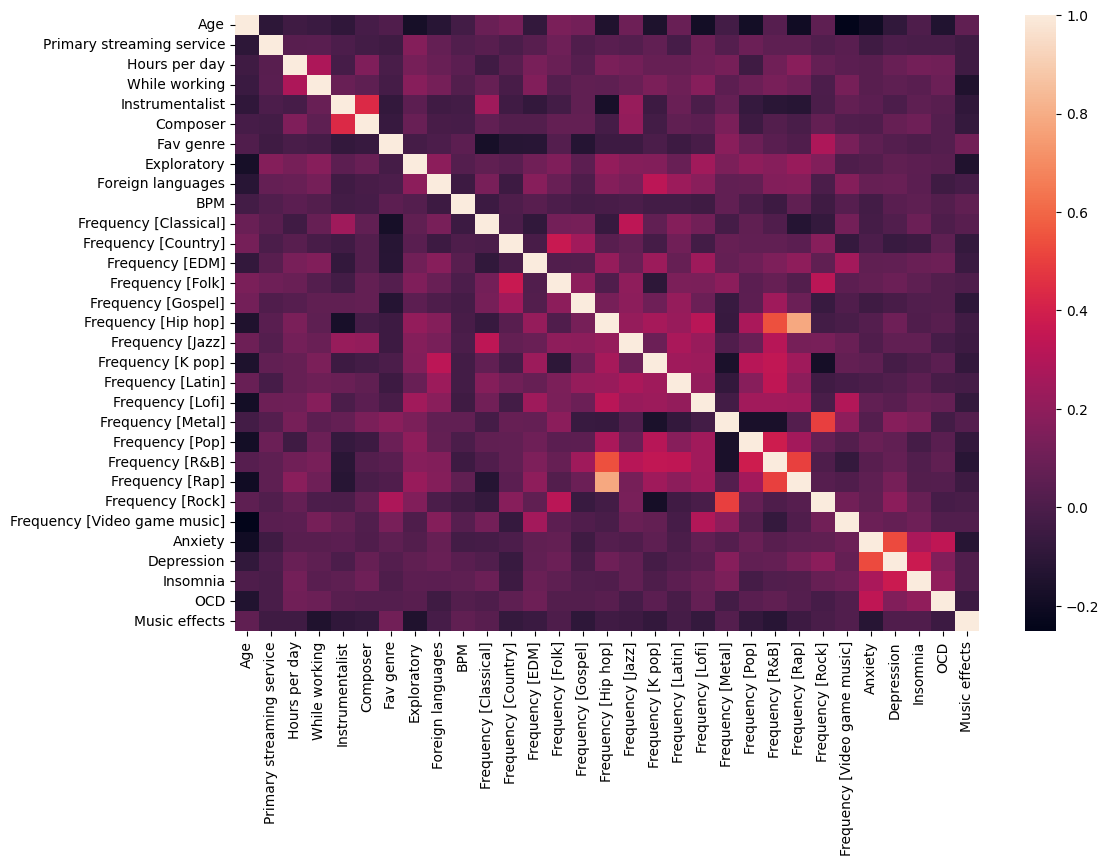

In [ ]:
import seaborn as sns


corr=data.corr()
sns.heatmap(corr)

# **Oversampling Dataset**

In [ ]:
import pandas as pd
from sklearn.utils import resample

# Carica il file CSV
#df = pd.read_csv('/path/to/mxmh_survey_results.csv')

# Separa il dataset in due gruppi: età <= 40 e età > 40
df_below_40 = data[data['Age'] <= 40]
df_above_40 = data[data['Age'] > 40]

# Esegui l'oversampling del gruppo con età > 40
df_above_40_oversampled = resample(df_above_40, replace=True, n_samples=2*len(df_below_40))

# Combina i due gruppi per ottenere il dataset bilanciato
balanced_df = pd.concat([df_below_40, df_above_40_oversampled])

# Stampa il numero di esempi per ogni gruppo di età
print(balanced_df['Age'].value_counts())
balanced_df.dropna(inplace=True)
# Salva il dataset bilanciato in un nuovo file CSV
balanced_df.to_csv('/content/sample_data/oversampled_dataset.csv', index=False)

print("Numero di righe totali del dataset originale:", len(data))
print("Numero di righe totali del dataset bilanciato:", len(balanced_df))

Age
49.0    106
41.0     84
56.0     81
42.0     74
18.0     71
58.0     62
43.0     58
60.0     58
19.0     56
53.0     55
17.0     52
44.0     51
61.0     51
63.0     47
21.0     40
16.0     38
20.0     36
22.0     32
59.0     31
23.0     29
80.0     29
69.0     28
48.0     28
68.0     26
55.0     25
57.0     25
73.0     24
70.0     23
89.0     21
15.0     20
64.0     19
65.0     19
24.0     19
26.0     17
25.0     17
46.0     17
72.0     17
74.0     17
14.0     16
50.0     16
27.0     16
67.0     15
51.0     13
32.0     13
28.0     11
29.0     10
30.0     10
31.0      9
36.0      7
34.0      7
33.0      6
13.0      6
37.0      5
40.0      5
35.0      5
38.0      4
12.0      1
10.0      1
39.0      1
Name: count, dtype: int64
Numero di righe totali del dataset originale: 616
Numero di righe totali del dataset bilanciato: 1680


**Qui inserisco depression come ultima feature, però devo prima trasformare la colonna depression in una colonna di 0 e di 1**

In [ ]:
#Trasformazione dei valori di Depression
balanced_df['Depression'] = balanced_df['Depression'].apply(lambda x: 0 if x <= 5 else 1)

In [ ]:
#Sposto come ultima colonna quella a cui sono interessato
#cols = list(balanced_df.columns)
#a, b = cols.index('Depression'), cols.index('Music effects')
#a, b = cols.index('Frequency [Rock]'), cols.index('Music effects')
#cols[b], cols[a] = cols[a], cols[b]
#balanced_df = balanced_df[cols]

In [ ]:
print(balanced_df)

      Age  Primary streaming service  Hours per day  While working  \
2    18.0                          4            4.0              0   
4    18.0                          4            4.0              1   
5    18.0                          4            5.0              1   
6    18.0                          5            3.0              1   
7    21.0                          4            1.0              1   
..    ...                        ...            ...            ...   
367  43.0                          4            1.0              1   
367  43.0                          4            1.0              1   
480  58.0                          2            3.0              1   
91   43.0                          1            6.0              1   
494  74.0                          1            1.0              0   

     Instrumentalist  Composer  Fav genre  Exploratory  Foreign languages  \
2                  0         0         15            0                  1   
4    

In [ ]:
fsg1 = FeatureStatisticsGenerator()

#Select dataframe
dataframes = [{'table': balanced_df, 'name': 'trainData1'}]
censusProto = fsg1.ProtoFromDataFrames(dataframes)   #crea un proto dal dataframe fornito

#Serialise --> Questa serializzazione serve a passare il mio dataset alla pagina html, la quale sarà stampata tramite l'oggetto display
protostr1 = base64.b64encode(censusProto.SerializeToString()).decode("utf-8")

#Select template
HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr1}";
        </script>"""

#Query and display
html = HTML_TEMPLATE.format(protostr1=protostr1)
display(HTML(html))

In [ ]:
#@title Visualize the Data - A deeper dive
SAMPLE_SIZE = 1600 #@param

dive = balanced_df.sample(SAMPLE_SIZE).to_json(orient='records')

HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="600"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""

html = HTML_TEMPLATE.format(jsonstr=dive)
display(HTML(html))

In [ ]:
# Used to label encode categorical values
labelencoder = LabelEncoder()


#Adesso non ho più una matrice di 33 colonne, ma di 32. Inoltre l'ultima colonna non è più Permissions ma Depression
balanced_df.dropna(inplace=True)
print(balanced_df.describe())


# This code identifies columns that need label encoding, and are then formatted if they do
print("\n\nColumn Names & formatting:\n")
for col in balanced_df.columns.values.tolist():
    if balanced_df[col].dtype == "object" or balanced_df[col].dtype == "bool":
        print("{:<30}".format(col), ":", "{:<30}".format(str(balanced_df[col].dtype)) , "Formatting to LabelEncoding")
        balanced_df[col] = labelencoder.fit_transform(balanced_df[col])
    else:
        print("{:<30}".format(col), ":", "{:<30}".format(str(balanced_df[col].dtype)) , "No formatting required.")

#WE WORKED IN PANDAS, MANAGING THE DATA LIKE A TABLE WITH ALSO NOT NUMERIC ELEMENT
#NOW, WITH THIS CONVERSION WE WORK IN NUMPY - IN NUMERIC DOMAIN
# Convert to array
#CREATING A MATRIX STARTING FROM THE TABLE
array = balanced_df.values

#we start from pandas table and arrive to numpy matrix (mandatory numeric)



# get seperated input and classifies, using a deep copy of a list, this is for ML models
X1 = array[:,0:30]
Y1 = array[:,30]

# Optional: to speed up deep learning model training - try this after algorithm development if the results are poor.
#----------------------------------------------------------
# Normalizing the input values (excluding the class value)
scaler = preprocessing.Normalizer().fit(X1)
X1 = scaler.transform(X1)

#
# print head post encoding
#
print("original")
balanced_df.describe()
print(Y1) #  --> Per Y mi aspetto 2 valori (0--> depr <=5, 1--> depr >5)

               Age  Primary streaming service  Hours per day  While working  \
count  1680.000000                1680.000000    1680.000000    1680.000000   
mean     44.444048                   3.189286       3.546994       0.786310   
std      18.779983                   1.547695       3.622644       0.410033   
min      10.000000                   0.000000       0.000000       0.000000   
25%      25.000000                   2.000000       1.500000       1.000000   
50%      46.000000                   4.000000       2.000000       1.000000   
75%      59.000000                   4.000000       4.000000       1.000000   
max      89.000000                   5.000000      24.000000       1.000000   

       Instrumentalist     Composer    Fav genre  Exploratory  \
count      1680.000000  1680.000000  1680.000000  1680.000000   
mean          0.278571     0.174405     9.118452     0.600000   
std           0.448430     0.379570     5.073576     0.490044   
min           0.000000     0

In [ ]:
# We are using stratification here, this startifies based on class values.
seed = 1
X_train1, X_test1, Y_train1, Y_test1  = train_test_split(X1, Y1, test_size=0.33, random_state=seed, shuffle = True, stratify=(Y1))


# Examine the class breakdown per dataset:

print("Training dataset length:", len(X_train1))
print("Testing dataset length:", len(X_test1))

class10TrainingPer = np.count_nonzero(Y_train1 == 0) / len(X_train1)
class10TestPer = np.count_nonzero(Y_test1 == 0) / len(X_test1)

class11TrainingPer = np.count_nonzero(Y_train1 == 1) / len(X_train1)
class11TestPer = np.count_nonzero(Y_test1 == 1) / len(X_test1)

print("\nPercentage of 0's in Training data: ", round(class10TrainingPer*100,2), "%")
print("Percentage of 0's in Test data    : ", round(class10TestPer*100,2), "%")
print("\nPercentage of 1's in Training data: ", round(class11TrainingPer*100,2), "%")
print("Percentage of 1's in Test data    : ", round(class11TestPer*100,2), "%")


Training dataset length: 1125
Testing dataset length: 555

Percentage of 0's in Training data:  65.16 %
Percentage of 0's in Test data    :  65.05 %

Percentage of 1's in Training data:  34.84 %
Percentage of 1's in Test data    :  34.95 %


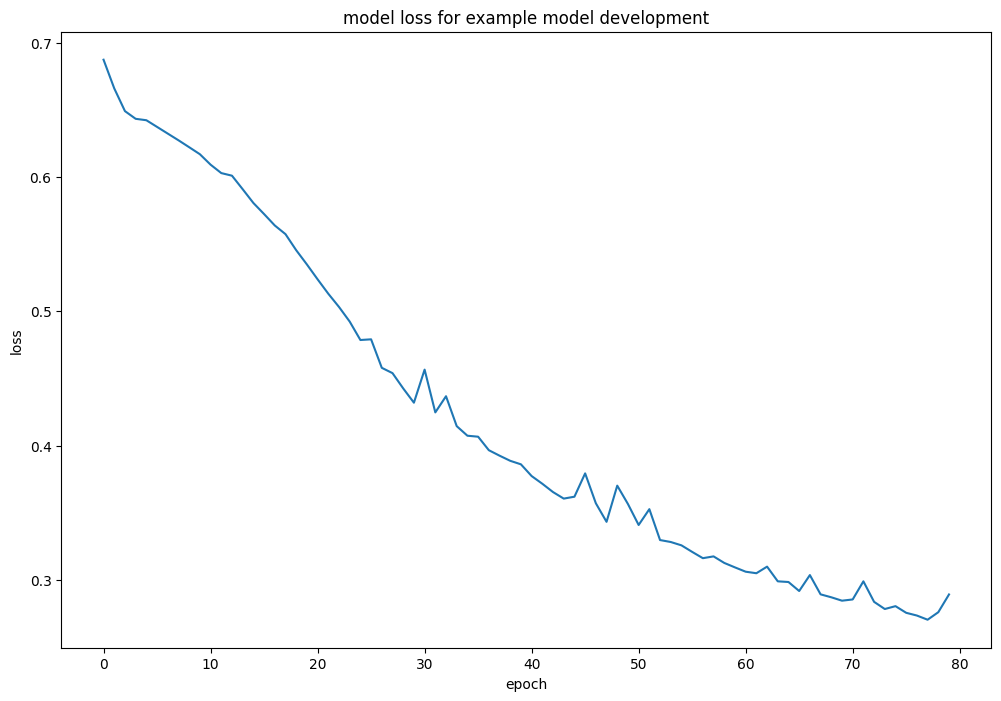

18/18 [==============================] - 0s 2ms/step - loss: 0.2338 - acc: 0.9009
Acuracy:  0.9009009003639221
18/18 [==============================] - 0s 2ms/step
Predicted    0  All
Actual             
0.0        361  361
1.0        194  194
All        555  555


In [ ]:
#@title Deep Learning Algorithm
# Need to rerun seed for each DL cell
tf.random.set_seed(seed)

# simple guide to sequential model
#https://keras.io/guides/sequential_model/
from tensorflow import keras
from keras.layers import Dense, SpatialDropout3D
from keras.models import Sequential


# Building the neural network
modeldl = keras.models.Sequential()
# First layer has 14 features as input and has 1000 perceptrons, it is using ReLu (do not change this) as an activation function
modeldl.add(Dense(1000, input_dim=30, activation='relu'))

# The following three layers have 100,100 and 50 perceptrons, they are also using ReLu (do not change this) as an activation function
# if you are tunning the network, you can modifiy the layers here, add remove of change the number of perceptrons.
modeldl.add(Dense(100, activation='relu'))
modeldl.add(Dense(100, activation='relu'))
modeldl.add(Dense(50, activation='relu'))

# The output layer has one neuron and sigmoid is the output activation function - do not change these.
modeldl.add(Dense(1, activation='sigmoid'))


# Compile model -  loss function of metrics
modeldl.compile(loss='binary_crossentropy', optimizer="adam", metrics=['acc'])

# Fit the model, change verbose to 2 to see the training cycles.
# Feel free here to modify the batch size and epochs!
results = modeldl.fit(X_train1, Y_train1, epochs=80, batch_size=1000, verbose=0)



#  matplotlib loss over epoch and confusion matrix
plt.plot(results.history['loss'])
plt.title('model loss for example model development')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

print("Acuracy: ", modeldl.evaluate(X_test1,Y_test1)[1])


# generate predictions from text data
dl_y_pred = modeldl.predict(X_test1)
dl_y_pred = np.argmax(dl_y_pred,axis=1)


# Confusion Matrix:
# overall TP, FP, TN, FN values, for binary values only
print(pd.crosstab(Y_test1, dl_y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))

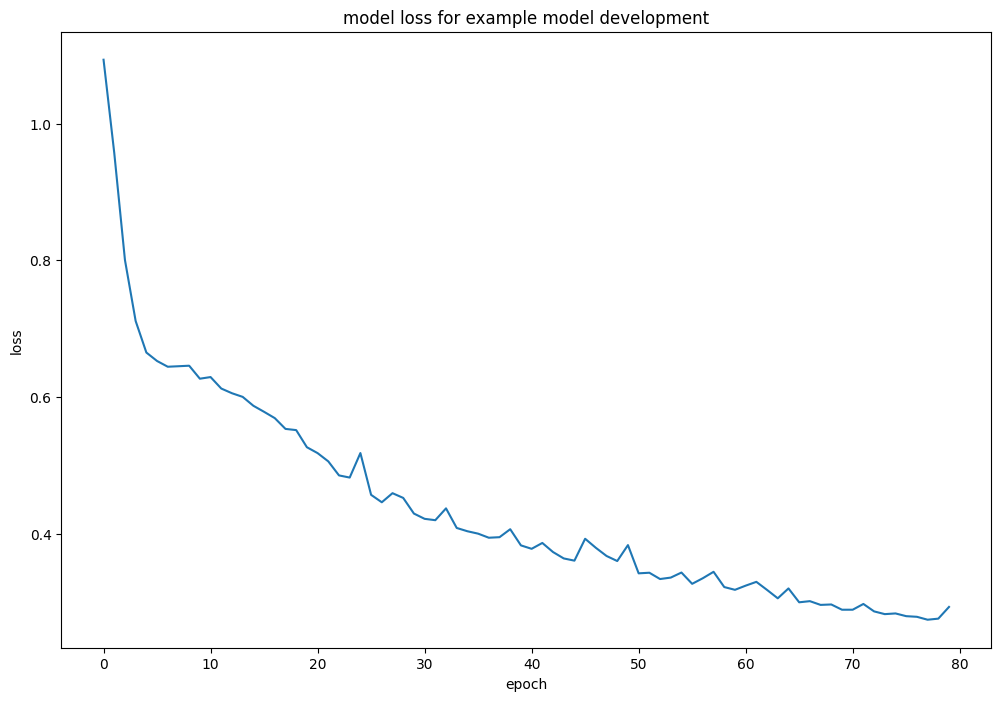

18/18 [==============================] - 0s 4ms/step - loss: 0.2360 - acc: 0.8973
Acuracy:  0.8972973227500916
18/18 [==============================] - 0s 5ms/step
          Predicted 0  Predicted 1  Total
Actual 0          341           20    361
Actual 1           37          157    194
Total             378          177    555


In [ ]:
#@title Deep Learning Algorithm
# Need to rerun seed for each DL cell
tf.random.set_seed(seed)

# simple guide to sequential model
#https://keras.io/guides/sequential_model/

# Building the neural network
modeldl = Sequential()
# First layer has 32 features as input and has 1000 perceptrons, it is using ReLu (do not change this) as an activation function
#modeldl.add(Dense(10000, input_dim=31, activation='relu'))
modeldl.add(Dense(1000, input_dim=30, activation='relu'))
# The following three layers have 100,100 and 50 perceptrons, they are also using ReLu (do not change this) as an activation function
# if you are tunning the network, you can modifiy the layers here, add remove of change the number of perceptrons.
#modeldl.add(Dense(5000, activation='relu'))
#modeldl.add(Dense(1000, activation='relu'))
modeldl.add(Dense(500, activation='relu'))
modeldl.add(Dense(500, activation='relu'))
#modeldl.add(Dense(300, activation='relu'))                #anche con questa stratificazione e con numero di percettroni eccessivamente
#modeldl.add(Dense(300, activation='relu'))                #alto, il codice impiega 6 minuti per effettuare le operazioni indicate
#modeldl.add(Dense(100, activation='relu'))                #ma non c'è alcun miglioramento in termini di errori
modeldl.add(Dense(100, activation='relu'))
#modeldl.add(Dense(50, activation='relu'))
#modeldl.add(Dense(10, activation='relu'))
# The output layer has one neuron and sigmoid is the output activation function - do not change these.
#modeldl.add(Dense(1, activation='sigmoid'))
modeldl.add(Dense(3, activation='softmax'))  # Numero di classi = 3

# Compile model -  loss function of metrics
modeldl.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['acc'])
#modeldl.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

# Fit the model, change verbose to 2 to see the training cycles.
# Feel free here to modify the batch size and epochs!
results = modeldl.fit(X_train1, Y_train1, epochs=80, batch_size=1000, verbose=0)



#  matplotlib loss over epoch and confusion matrix
plt.plot(results.history['loss'])
plt.title('model loss for example model development')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

print("Acuracy: ", modeldl.evaluate(X_test1,Y_test1)[1])


# generate predictions from text data
dl_y_pred = modeldl.predict(X_test1)
dl_y_pred = np.argmax(dl_y_pred,axis=1)

# Calcola la matrice di confusione
cm = confusion_matrix(Y_test1.flatten(), dl_y_pred)

# Creazione del DataFrame per la matrice di confusione
confusion_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
confusion_df['Total'] = confusion_df.sum(axis=1)
confusion_df.loc['Total'] = confusion_df.sum()

print(confusion_df)
# Confusion Matrix:
# overall TP, FP, TN, FN values, for binary values only
#print(pd.crosstab(Y_test, dl_y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))
#print(pd.crosstab(Y_test.flatten(), dl_y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))
#labels = [0, 1, 2]  # Specifica tutte le etichette di classe possibili
#print(pd.crosstab(Y_test.flatten(), dl_y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True, labels=labels))

In [ ]:
#@title Decision Tree algorithm

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


# You can modify the maximum depth of the tree, you can find more detauils on this and pruning options at:
# Link: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
modeldt = DecisionTreeClassifier(max_depth=6)
                                                  #qui invece si nota che aumentando la depth, diminuisce l'accuracy
modeldt.fit(X_train1, Y_train1)

results = modeldt.score(X_test1, Y_test1)

print(results)

# Generate predictions from text data
dt_y_pred = modeldt.predict(X_test1)

# Confusion Matrix:
# overall TP, FP, TN, FN values, for binary values only
print(pd.crosstab(Y_test1, dt_y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))

# print the decision tree rules:
print("\n\nDecision Tree Rules:")
print("*"*40)
text_representation = tree.export_text(modeldt)
print(text_representation)


with open("newModelData.log", "w") as newfile:
  newfile.write(text_representation )

0.8936936936936937
Predicted  0.0  1.0  All
Actual                  
0.0        332   29  361
1.0         30  164  194
All        362  193  555


Decision Tree Rules:
****************************************
|--- feature_26 <= 0.03
|   |--- feature_19 <= 0.02
|   |   |--- feature_0 <= 0.30
|   |   |   |--- feature_24 <= 0.01
|   |   |   |   |--- feature_26 <= 0.01
|   |   |   |   |   |--- feature_20 <= 0.01
|   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |--- feature_20 >  0.01
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- feature_26 >  0.01
|   |   |   |   |   |--- feature_19 <= 0.01
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- feature_19 >  0.01
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |--- feature_24 >  0.01
|   |   |   |   |--- feature_24 <= 0.02
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- feature_24 >  0.02
|   |   |   |   |   |--- feature_24 <= 0.02
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |

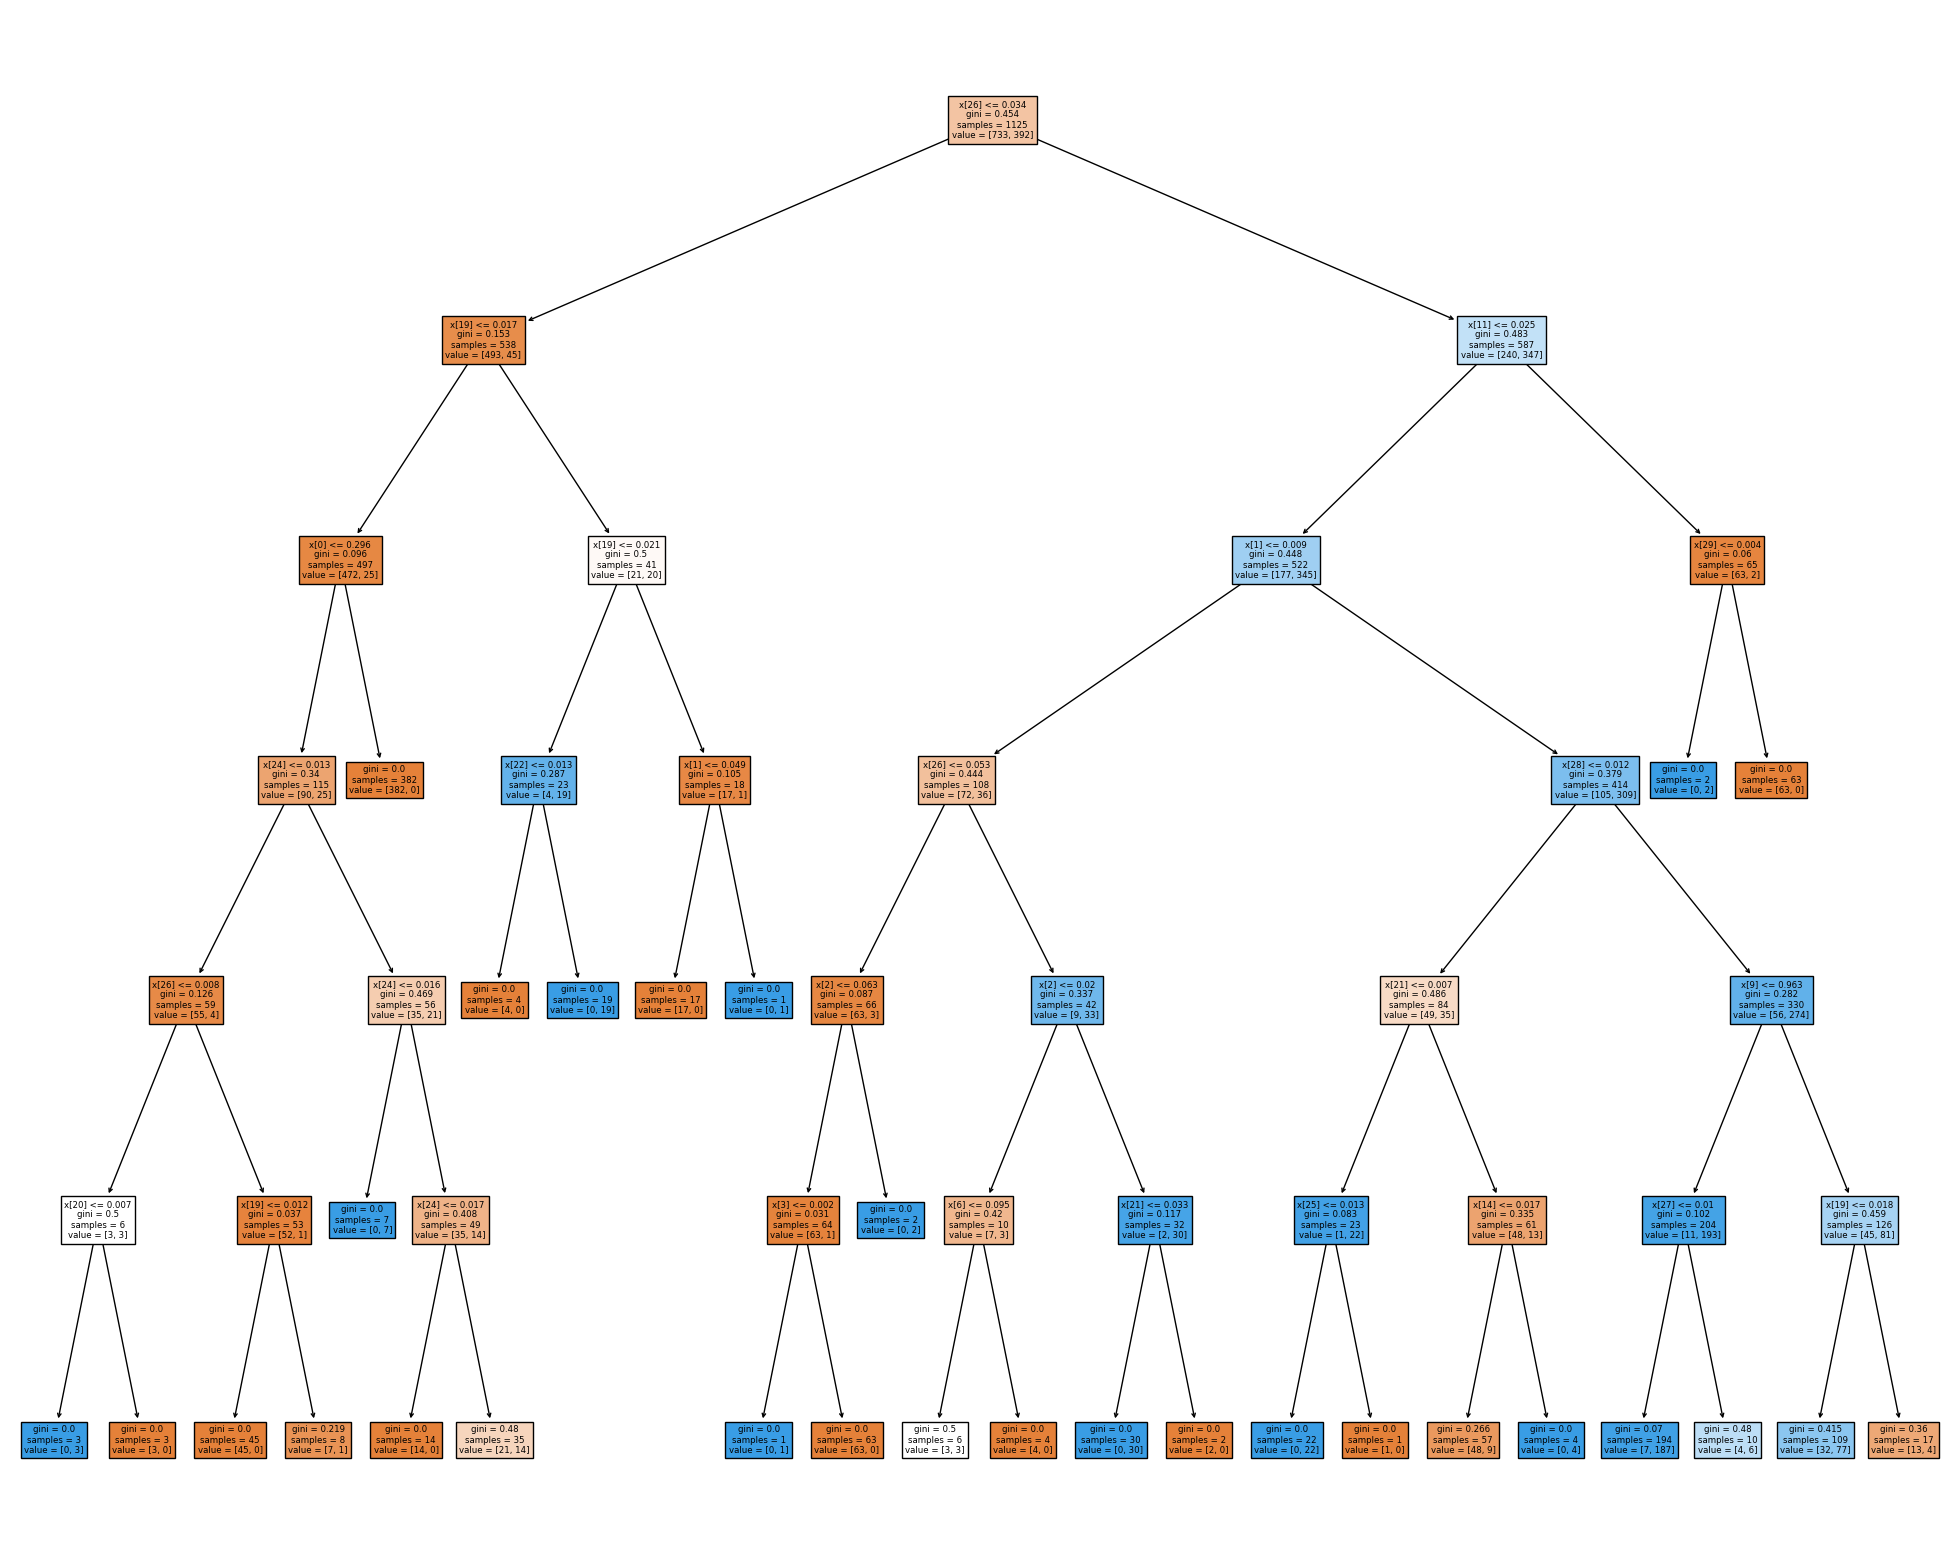

In [ ]:
fig= plt.figure(figsize=(25,20))
output= tree.plot_tree(modeldt, filled=True)

In [ ]:
#@title Definition to provide the metrics
def subMetrics(targetGroup, act, pred):
  print("Metrics for: ", targetGroup)
  correct = 0
  # parse both lists to numpy arrays -- usually convesion from pandas to numpy
  act = np.array(act)
  pred = np.array(pred)
  # There may be an easier way to do this, however, I believe it is a manual process!
  for index, item in enumerate(act):
    if item == pred[index]:
      correct += 1   #correct is not updated if the actual is different from predicted
  # print accuracy, and the confusion matrix
  accuracy = round((correct / len(act)) * 100,2)
  return accuracy

In [ ]:
NOdepr_pred = []           # No depression -  was label encoded as 0
NOdepr_actual_class = []


YESdepr_pred = []         # Depression was label encoded as 1
YESdepr_actual_class = []


#Depression is labeled 28

# Populate the confusion matrix grouping by gender (col index 9) you could also do this via group by but would need to convert back to pandas dataframe.
# When grouping by multi class, you will have to modify the below code to include multi class, as for this example there is only two.
# Also we are using the DT algorithm here, you can change this to DL if you selected that algorithm.
for index,row in enumerate(X_test1):
    if row[28] == 0:       # No depress
        NOdepr_pred.append(dt_y_pred[index])
        NOdepr_actual_class.append(Y_test1[index])
    else:     #  Depress
        YESdepr_pred.append(dt_y_pred[index])
        YESdepr_actual_class.append(Y_test1[index])


# Print the representation of each target group
print("(No) depressed instances in the test set:", len(NOdepr_pred))
print("(Yes) depressed instances in the test set:  ", len(YESdepr_pred))


print("\n"*2)
# Confusion Matrix:
# overall TP, FP, TN, FN values, for binary values only
ACC=subMetrics("NO DEP", NOdepr_actual_class, NOdepr_pred)


print("Accuracy:", ACC, "%")
print("\n")
print(pd.crosstab( np.array(NOdepr_actual_class),  np.array(NOdepr_pred), rownames=['Actual'], colnames=['Predicted'], margins=True))

print("\n")
print("\n")
print("\n")
print("\n")
print("\n")

ACC_M=subMetrics("YES DEP", YESdepr_actual_class, YESdepr_pred)
print("Accuracy:", ACC_M, "%")
print("\n")
print(pd.crosstab( np.array(YESdepr_actual_class),  np.array(YESdepr_pred), rownames=['Actual'], colnames=['Predicted'], margins=True))



(No) depressed instances in the test set: 105
(Yes) depressed instances in the test set:   450



Metrics for:  NO DEP
Accuracy: 91.43 %


Predicted  0.0  1.0  All
Actual                  
0.0         85    2   87
1.0          7   11   18
All         92   13  105










Metrics for:  YES DEP
Accuracy: 88.89 %


Predicted  0.0  1.0  All
Actual                  
0.0        247   27  274
1.0         23  153  176
All        270  180  450


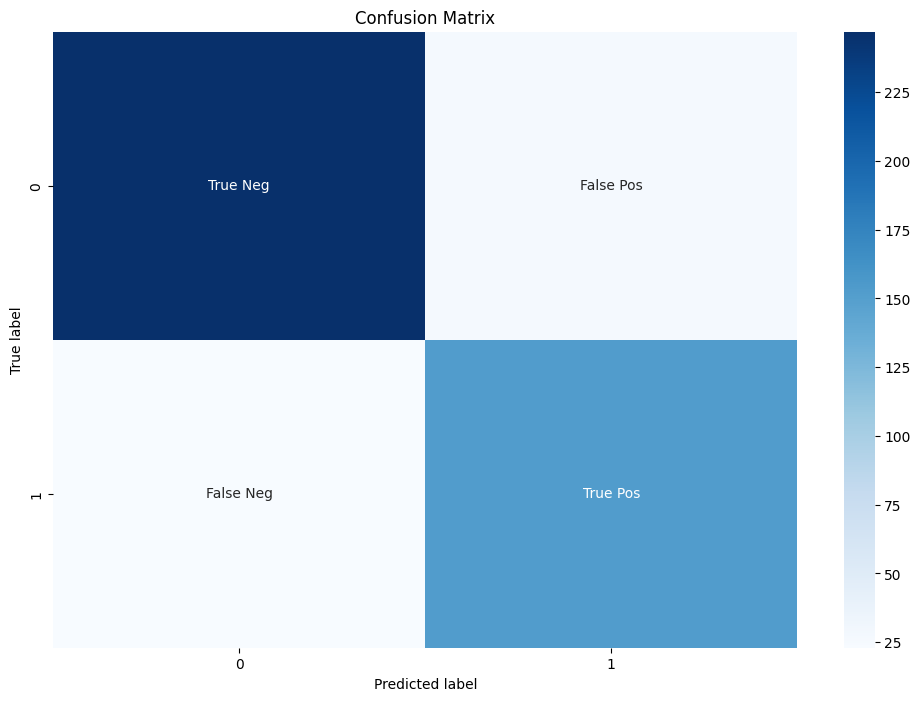

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Calculate confusion matrix
conf_matrix = confusion_matrix(YESdepr_actual_class,YESdepr_pred)


# Create labels for the matrix
labels = ["True Neg","False Pos","False Neg","True Pos"]
labels = np.asarray(labels).reshape(2,2)

# Create a heatmap
sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')

# Adding titles and labels
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Display the plot
plt.show()